# Distortion correction with orthorhombic symmetry
This example showcases how to use the distortion correction workflow with landmarks that are not at symmetry-equivalent positions, such as for orthorhombic systems with different in-plane axis parameters.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import sed
from sed.dataset import dataset

%matplotlib widget

## Load Data
For this example, we use the example data from WSe2. Even though the system is hexagonal, we will use it for demonstration.

In [2]:
dataset.get("WSe2") # Put in Path to a storage of at least 20 GByte free space.
data_path = dataset.dir # This is the path to the data
scandir, _ = dataset.subdirs # scandir contains the data, _ contains the calibration files

INFO - Not downloading WSe2 data as it already exists at "/home/runner/work/sed/sed/docs/tutorial/datasets/WSe2".
Set 'use_existing' to False if you want to download to a new location.


INFO - Using existing data path for "WSe2": "/home/runner/work/sed/sed/docs/tutorial/datasets/WSe2"


INFO - WSe2 data is already present.


In [3]:
# create sed processor using the config file with time-stamps:
sp = sed.SedProcessor(folder=scandir, user_config="../sed/config/mpes_example_config.yaml", time_stamps=True, verbose=True)
sp.add_jitter()

Folder config loaded from: [/home/runner/work/sed/sed/docs/tutorial/sed_config.yaml]
User config loaded from: [/home/runner/work/sed/sed/docs/sed/config/mpes_example_config.yaml]
Default config loaded from: [/home/runner/work/sed/sed/sed/config/default.yaml]


Get slice for momentum calibration

  0%|          | 0/34 [00:00<?, ?it/s]

interactive(children=(IntSlider(value=203, description='plane', max=290), IntSlider(value=10, description='wid…

Button(description='apply', style=ButtonStyle())

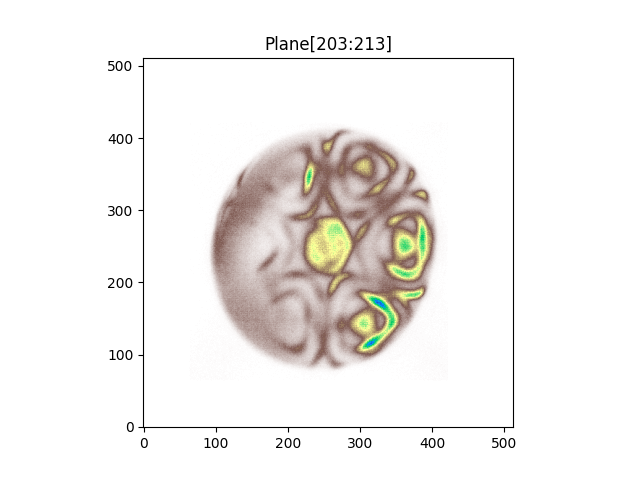

In [4]:
sp.bin_and_load_momentum_calibration(df_partitions=100, plane=203, width=10, apply=True)

## Feature definition:
We will describe the symmetry of the system with a 4-fold symmetry, and select two K points and two M points as symmetry points (as well as the Gamma point).

interactive(children=(Dropdown(description='Point:', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_classe…

interactive(children=(FloatText(value=252.0, description='point_x'), FloatText(value=355.0, description='point…

Button(description='apply', style=ButtonStyle())

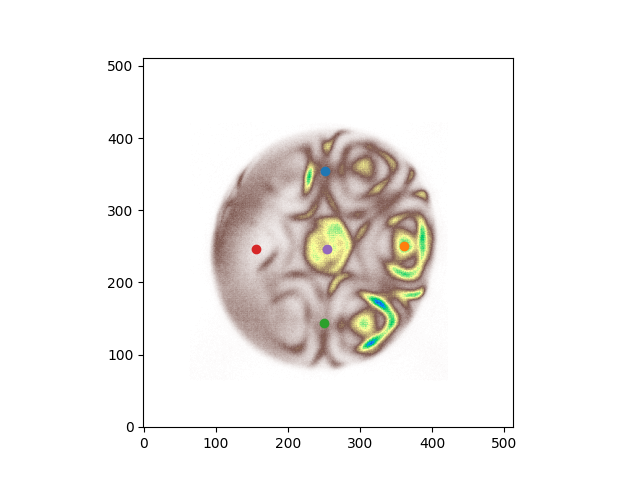

In [5]:
features = np.array([[252., 355.], [361., 251.], [250., 144.], [156., 247.], [254., 247.]])
sp.define_features(features=features, rotation_symmetry=4, include_center=True, apply=True)
# Manual selection: Use a GUI tool to select peaks:
# sp.define_features(rotation_symmetry=4, include_center=True)

## Spline-warp generation: 
For the spline-warp generation, we need to tell the algorithm the difference in length of Gamma-K and Gamma-M. This we can do using the ascale parameter, which can either be a single number (the ratio), or a list of length ``rotation_symmetry`` defining the relative length of the respective vectors.

In [6]:
gamma_m = np.pi/3.28
gamma_k = 2/np.sqrt(3)*np.pi/3.28
# Option 1: Ratio of the two distances:
#sp.generate_splinewarp(include_center=True, ascale=gamma_k/gamma_m)
# Option 2: List of distances:
sp.generate_splinewarp(include_center=True, ascale=[gamma_m, gamma_k, gamma_m, gamma_k])

Calculated thin spline correction based on the following landmarks:
pouter: [[252. 355.]
 [361. 251.]
 [250. 144.]
 [156. 247.]]
pcent: (254.0, 247.0)
Original slice with reference features


Corrected slice with target features


Original slice with target features


interactive(children=(FloatSlider(value=1.0, description='scale', max=1.2, min=0.8, step=0.01), FloatSlider(va…

Button(description='apply', style=ButtonStyle())

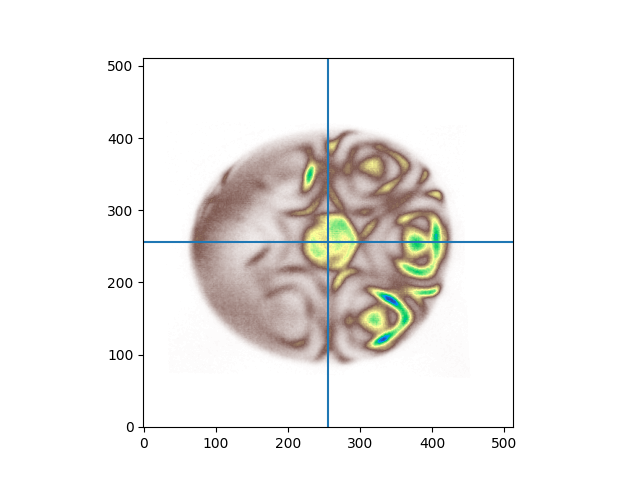

Output()

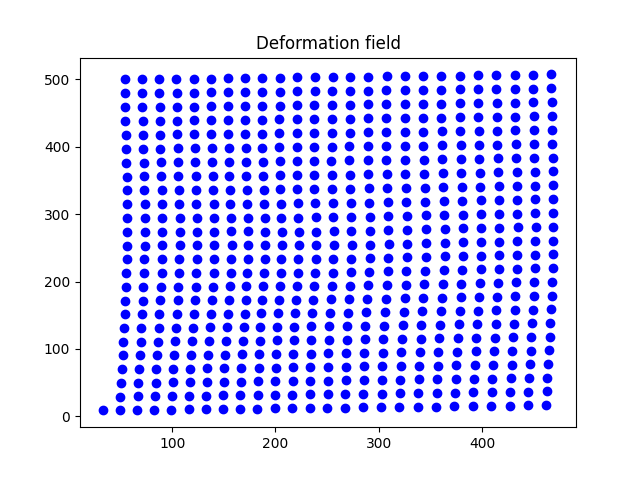

In [7]:
sp.pose_adjustment(xtrans=4, ytrans=7, angle=1, apply=True)

In [8]:
sp.apply_momentum_correction()

Adding corrected X/Y columns to dataframe:
Calculating inverse deformation field, this might take a moment...


Dask DataFrame Structure:
                       X        Y        t      ADC timeStamps       Xm       Ym
npartitions=100                                                                 
                 float64  float64  float64  float64    float64  float64  float64
                     ...      ...      ...      ...        ...      ...      ...
...                  ...      ...      ...      ...        ...      ...      ...
                     ...      ...      ...      ...        ...      ...      ...
                     ...      ...      ...      ...        ...      ...      ...
Dask Name: apply_dfield, 206 graph layers


## Momentum calibration with orthorhombic axes
For the momentum calibration using symmetry points with non-equal distances, the option ``equiscale`` can be used:

interactive(children=(IntText(value=256, description='point_a_x'), IntText(value=155, description='point_a_y')…

Button(description='apply', style=ButtonStyle())

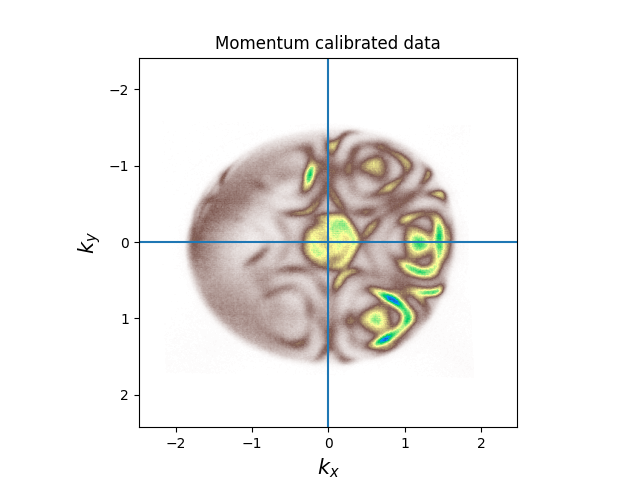

In [9]:
point_a = [256, 155]
point_b = [370, 256]
sp.calibrate_momentum_axes(point_a=point_a, point_b=point_b, k_coord_a=[0, gamma_m], k_coord_b=[gamma_k, 0], equiscale=False, apply=True)

In [10]:
sp.apply_momentum_calibration()

Adding kx/ky columns to dataframe:
Dask DataFrame Structure:
                       X        Y        t      ADC timeStamps       Xm       Ym       kx       ky
npartitions=100                                                                                   
                 float64  float64  float64  float64    float64  float64  float64  float64  float64
                     ...      ...      ...      ...        ...      ...      ...      ...      ...
...                  ...      ...      ...      ...        ...      ...      ...      ...      ...
                     ...      ...      ...      ...        ...      ...      ...      ...      ...
                     ...      ...      ...      ...        ...      ...      ...      ...      ...
Dask Name: assign, 216 graph layers


## Bin the top of the valence band

  0%|          | 0/34 [00:00<?, ?it/s]

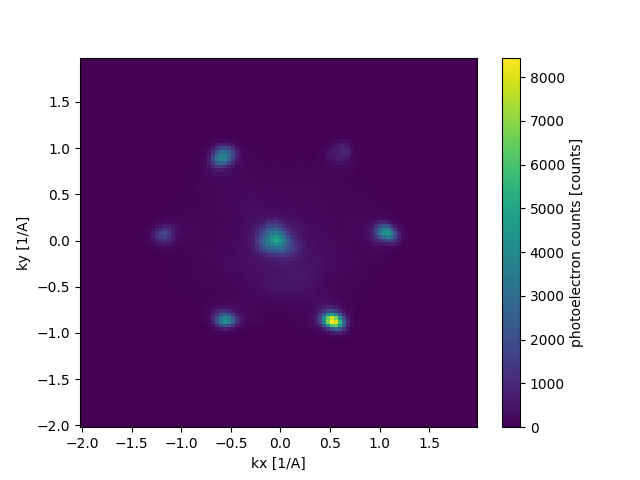

In [11]:
axes = ['kx', 'ky']
bins = [100, 100]
ranges = [[-2, 2], [-2, 2]]
res = sp.compute(bins=bins, axes=axes, ranges=ranges, filter=[{"col":"t", "lower_bound": 66100, "upper_bound": 66300}])
plt.figure()
res.T.plot()